# Home value prediction

This project indicate median cost of housing in California in 1990. The project considers two logistic regression models with different feature sets. A comparison of models was made and the best one was determined. The project implements a distributed computing approach based on the Hadoop ecosystem, namely Apache Spark. Apache Spark is a data processing framework that can quickly perform processing tasks on very large data sets, and can also distribute data processing tasks across multiple computers, either on its own or in tandem with other distributed computing tools. The main goal of the project is to show practical knowledge of Apache Spark.


**Research Progress**

  1. Data preparation
  2. Model training
  3. Analysis of results
  4. Conclusions


## Data Preprocessing

It is no longer a secret that high-quality data pre-processing is one of the key factors for the successful operation of the model.
Raw data can cause poor model results and, in some cases, the appearance of errors in this model. For these reasons, it is necessary to make a qualitative data preprocessing in the beginning.

Real data often contains noise, gaps, duplicates, and may also be in an unusable format that cannot be passed to the model for further work. Good data preprocessing will improve the accuracy of predictions and the efficiency of the model.

### Data review and analysis

In [1]:
import pandas as pd
import numpy as np
import pyspark
import pyspark.sql.functions as F

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import OneHotEncoder, StringIndexer, Imputer , VectorAssembler , StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import pandas_udf

spark = SparkSession.builder \
                    .master("local") \
                    .appName("Predict of cost California Housing") \
                    .getOrCreate()

In [2]:
df_housing = spark.read.load(r'C:\Users\Vadim\Documents\Datasets\cal_housing.csv', format='csv', sep=',', inferschema=True, header='true')
df_housing.printSchema() 

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [3]:
columns = df_housing.columns

for column in columns:
    check_col = F.col(column).cast(FloatType()).isin([None, np.nan])
    print(column, df_housing.filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


In [4]:
df_housing.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
print(pd.DataFrame(df_housing.dtypes, columns=['column', 'type']).head(10))
df_housing.show(10)

               column    type
0           longitude  double
1            latitude  double
2  housing_median_age  double
3         total_rooms  double
4      total_bedrooms  double
5          population  double
6          households  double
7       median_income  double
8  median_house_value  double
9     ocean_proximity  string
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500

In [6]:
df_housing.toPandas().describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


**Conclusion:**

The dataset has 10 columns, 20640 rows. All columns except one represent a `double` data type. In the `ocean_proximity` column, the data type is `string`. In the future, for the model to work correctly, it will be necessary to convert this type to a numeric one. There are gaps in the `total_bedrooms` column. In the future, for the model to work correctly, gaps will also need to be processed.

In [7]:
print('Number of households: ', df_housing.select().count())
print('Number of households with a median cost greater than $500,000:', df_housing.filter(F.col('median_house_value') > 500000).count())

Количество домовладений:  20640
Количество домовладений где медианная стоимость больше $500000: 965


<AxesSubplot:xlabel='ocean_proximity', ylabel='avg_median_income'>

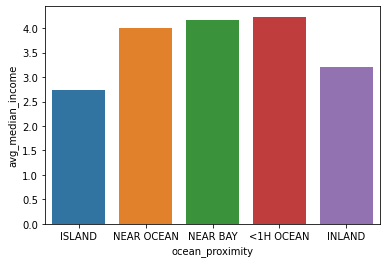

In [8]:
import seaborn as sns

df_wealthy = df_housing.groupBy('ocean_proximity').agg(F.avg('median_income')).toPandas()
df_wealthy.columns = ['ocean_proximity', 'avg_median_income']
sns.barplot(x=df_wealthy.ocean_proximity, y=df_wealthy.avg_median_income)

People with high incomes prefer to settle in residential areas that are no more than an hour's drive from the ocean or near the bay.

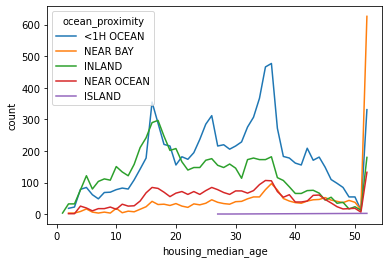

In [33]:
df_ages = df_housing.groupBy('housing_median_age', 'ocean_proximity').count().toPandas()
sns.lineplot(data=df_ages, 
    x='housing_median_age', 
    y='count', 
    hue='ocean_proximity'
);

The graph shows that people under 20 are more likely to live in mainland California (INLAND) and within an hour's drive of the ocean. Older generations prefer to settle within an hour's drive to the ocean and near the bay.

Let's create several new columns with features for better model:

In [10]:
df_housing = df_housing.withColumn('rooms_per_household', F.col('total_rooms') / F.col('households'))
df_housing = df_housing.withColumn('population_in_household', F.col('population') / F.col('households'))
df_housing = df_housing.withColumn('bedroom_index', F.col('total_bedrooms') / F.col('total_rooms'))

Column with a random target feature for future validation of working models:Столбец с рандомным целевым признаком для будущей проверки на адекватность рабочих моделей:

In [12]:
df_housing = df_housing.withColumn("random_median_house_value", lit(df_housing.groupBy().avg("median_house_value").take(1)[0][0]))

In [13]:
df_housing.toPandas().head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,population_in_household,bedroom_index,random_median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,2.555556,0.146591,206855.816909
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,2.109842,0.155797,206855.816909
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,2.802260,0.129516,206855.816909
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,2.547945,0.184458,206855.816909
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,2.181467,0.172096,206855.816909


### Processing missing values

In [14]:
imputer = Imputer(strategy='median', inputCol='total_bedrooms', outputCol='total_bedrooms')
df_housing = imputer.fit(df_housing).transform(df_housing)

In [16]:
df_housing = df_housing.withColumn('bedroom_index', F.col('total_bedrooms') / F.col('total_rooms'))

In [17]:
df_housing.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   longitude                  20640 non-null  float64
 1   latitude                   20640 non-null  float64
 2   housing_median_age         20640 non-null  float64
 3   total_rooms                20640 non-null  float64
 4   total_bedrooms             20640 non-null  float64
 5   population                 20640 non-null  float64
 6   households                 20640 non-null  float64
 7   median_income              20640 non-null  float64
 8   median_house_value         20640 non-null  float64
 9   ocean_proximity            20640 non-null  object 
 10  rooms_per_household        20640 non-null  float64
 11  population_in_household    20640 non-null  float64
 12  bedroom_index              20640 non-null  float64
 13  random_median_house_value  20640 non-null  flo

The gaps are filled✔️

### Transformation of categorical features

In [18]:
ocean_proximity_idexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_Index")
df_transformed = ocean_proximity_idexer.fit(df_housing).transform(df_housing)

onehotencoder_ocean_proximity_vector = OneHotEncoder(inputCol="ocean_proximity_Index", outputCol="ocean_proximity_vec")
vec_housing = onehotencoder_ocean_proximity_vector.fit(df_transformed).transform(df_transformed)
vec_housing.toPandas().head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,population_in_household,bedroom_index,random_median_house_value,ocean_proximity_Index,ocean_proximity_vec
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,2.555556,0.146591,206855.816909,3.0,"(0.0, 0.0, 0.0, 1.0)"
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,2.109842,0.155797,206855.816909,3.0,"(0.0, 0.0, 0.0, 1.0)"
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,2.802260,0.129516,206855.816909,3.0,"(0.0, 0.0, 0.0, 1.0)"
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,2.547945,0.184458,206855.816909,3.0,"(0.0, 0.0, 0.0, 1.0)"
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,2.181467,0.172096,206855.816909,3.0,"(0.0, 0.0, 0.0, 1.0)"


### Transformation of numerical features

In [19]:
numerical_cols = ['longitude', 
                  'latitude', 
                  'housing_median_age', 
                  'total_rooms',
                  'total_bedrooms',
                  'population', 
                  'households', 
                  'median_income',
                  'rooms_per_household',
                  'population_in_household',
                  'bedroom_index']

target = 'median_house_value'
random_target = 'random_median_house_value'

numerical_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
vec_housing = numerical_assembler.transform(vec_housing) 

standardScaler = StandardScaler(inputCol='numerical_features',  outputCol="numerical_features_scaled")
vec_housing = standardScaler.fit(vec_housing).transform(vec_housing) 

**Combining features into one vector for the ML algorithm**

In [20]:
all_features = ['ocean_proximity_vec', 'numerical_features_scaled']


final_assembler = VectorAssembler(inputCols=all_features, outputCol="features") 
vec_housing2 = final_assembler.transform(vec_housing)

In [21]:
vec_housing2.select(all_features).show(5) 

+-------------------+-------------------------+
|ocean_proximity_vec|numerical_features_scaled|
+-------------------+-------------------------+
|      (4,[3],[1.0])|     [-61.007269596069...|
|      (4,[3],[1.0])|     [-61.002278409814...|
|      (4,[3],[1.0])|     [-61.012260782324...|
|      (4,[3],[1.0])|     [-61.017251968579...|
|      (4,[3],[1.0])|     [-61.017251968579...|
+-------------------+-------------------------+
only showing top 5 rows



### Features sampling

**Sampling based on all features**

In [22]:
RANDOM_SEED = 123456
train_data, test_data = vec_housing2.randomSplit([.75,.25], seed=RANDOM_SEED)
print(train_data.count(), test_data.count()) 

15433 5207


## Training models

### Model trained on all features

In [23]:
lr = LinearRegression(labelCol=target, featuresCol="features", regParam=0.1, solver="normal")
model = lr.fit(train_data)

### Model trained on numerical features

In [24]:
lr_2 = LinearRegression(labelCol=target, featuresCol="numerical_features_scaled", regParam=0.1, solver="normal")
model_2 = lr_2.fit(train_data)

### Random (random) model to test the sanity of the previous two models

In [25]:
lr_3 = LinearRegression(labelCol=random_target, featuresCol="numerical_features_scaled", regParam=0.1, solver="normal")
model_3 = lr_3.fit(train_data)

## Analysis of results

### Metrics RMSE, MAE, R2 of the model trained on all features

In [26]:
predictions = model.transform(test_data)

In [27]:
evaluator_rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")
rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
R2 = evaluator_r2.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Mean absolute error (MAE) on test data = %g" % mae)
print("Coefficient of determination (R2) on test data = %g" % R2)

Root Mean Squared Error (RMSE) on test data = 66675.4
Mean absolute error (MAE) on test data = 48510.5
Coefficient of determination (R2) on test data = 0.664534


### Metrics RMSE, MAE, R2 of the model trained on numerical features

In [28]:
predictions_2 = model_2.transform(test_data)

In [29]:
evaluator_rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")
rmse_2 = evaluator_rmse.evaluate(predictions_2)
mae = evaluator_mae.evaluate(predictions_2)
R2 = evaluator_r2.evaluate(predictions_2)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_2)
print("Mean absolute error (MAE) on test data = %g" % mae)
print("Coefficient of determination (R2) on test data = %g" % R2)

Root Mean Squared Error (RMSE) on test data = 67253.2
Mean absolute error (MAE) on test data = 49164.5
Coefficient of determination (R2) on test data = 0.658694


### Metrics RMSE, MAE, R2 of the random model

In [30]:
predictions_3 = model_3.transform(test_data)

In [31]:
evaluator_rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")
rmse_2 = evaluator_rmse.evaluate(predictions_3)
mae = evaluator_mae.evaluate(predictions_3)
R2 = evaluator_r2.evaluate(predictions_3)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_2)
print("Mean absolute error (MAE) on test data = %g" % mae)
print("Coefficient of determination (R2) on test data = %g" % R2)

Root Mean Squared Error (RMSE) on test data = 115120
Mean absolute error (MAE) on test data = 90764.2
Coefficient of determination (R2) on test data = -4.6925e-05


**The metrics of the working models are significantly superior in quality to the metrics of the random model.**
- Root Mean Squared Error by 43%
- Mean absolute error (MAE) by 46%
- The coefficient of determination (R2) of the random model is zero, which means the model is of low significance.

**Hence, it can be concluded that working models have passed the sanity test.**

## General conclusion

During the development of the project, two linear regression models were built to predict the cost of home ownership in airplanes. The first model is based on categorical and numerical features, the second one is based only on numerical ones. The quality of the models was assessed using 3 metrics: root mean square error (RMSE), mean absolute error (MAE) and coefficient of determination (R2). The smaller the RMSE and MAE, the more accurate the model's predictions. The coefficient of determination close to unity also characterizes the best quality of the models.

**Quality metrics of learning models on all features:**
- Root mean square error (RMSE) = 66675.4
- Mean absolute error (MAE) = 48510.5
- Coefficient of determination (R2) = 0.664534

**Quality metrics for learning models based on numerical features:**
- Root mean square error (RMSE) for test data = 67253.2
- Mean absolute error (MAE) on test data = 49164.5.
- Coefficient of determination (R2) according to test data = 0.658694

The model trained on all features turned out to be more efficient. This model has a mean square error less than 1%,
the average absolute error is 1.3%, the coefficient of determination is 1% higher.
Both models are superior in quality to a random model (if the model was made randomly) by 42%.